In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
plt.rcParams.update({'font.size':20})

## How do numerical models work and why is my model *not* working?
<img src="variables-climate-models-Earth-forces-behaviour-materials.jpg" alt="Climate model schematic" style="width: 500px;"/>

## Finite differencing

Most of the models used in earth sciences are solving partial differential equations. In order to simulate differential equations, we need to discretize space and time dimensions. For example take the equation

$\frac{\partial c(x,t)}{\partial t} = u(x) \frac{\partial c(x,t)}{\partial x}$

$c(x,0) = c_0$

$c(0,t) = 0$

We first discretize in time

$\frac{c^{n+1}-c^n}{\Delta t} = u(x) \frac{\partial c^n}{\partial x}$

Next we discretize in space

$\frac{c^{n+1}-c^n}{\Delta t} = u_{i-1/2} \frac{c^n_{i}-c^n_{i-1}}{\Delta x}$

Re-arranging, we solve for the concentration at a future time as

$c^{n+1} = c^n + \frac{\Delta t}{\Delta x} u_{i-1/2} (c^n_{i}-c^n_{i-1})$

### Numerical dissipation

We will use an upwind finite difference scheme, to illustrate the concept of **numerical dissipation**

In [3]:
def upwind_difference1D(c,u,dt,dx):
    cnew = c[1:] - (u[1:]+u[:-1])/2*dt/dx*(c[1:]-c[:-1])
    cnew = np.append(0.,cnew) # boundary condition
    return cnew

Text(0, 0.5, 'c')

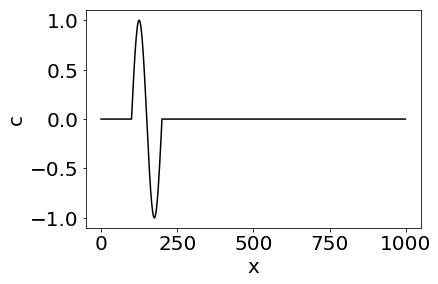

In [4]:
# Initial condition
c0 = np.zeros(1000)
Lx = 100
c0[101:200] = np.sin(2*np.pi*np.arange(101,200)/Lx)
x = np.arange(1000)
plt.plot(x,c0,'k')
plt.xlabel('x')
plt.ylabel('c')

## Exercise: Effects of numerical parameters
Alter the parameters 'dt', 'dx', and 'u' and run the three cells below. Describe the differences as you change the parameters

In [5]:
# Choose parameters
dt = 1.5
dx = 1.0
u  = 0.5*np.ones(c0.shape)
print(max(u)*dt/dx)

0.75


In [6]:
T = 1000
nt = T/dt # number of timesteps
# Numerical solution
c1 = c0
for i in np.arange(nt):
    c1 = upwind_difference1D(c1,u,dt,dx)

Maximum value is 0.7838765311254552


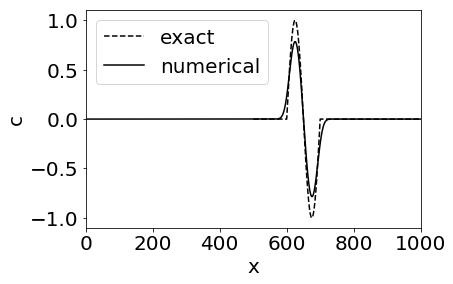

In [7]:
plt.plot(x+u*dt*nt,c0,'k--')
plt.plot(x,c1,'k')
plt.xlim((0,1000))
plt.legend(('exact','numerical'))
plt.xlabel('x')
plt.ylabel('c')
print('Maximum value is '+str(max(c1)))

### Numerical dispersion

By altering the *numerical solver* we can reduce the numerical diffusion. Instead of the previous upwind scheme, we will instead use a centered differencing scheme

$\frac{c^{n+1}-c^n}{\Delta t} = u_{i} \frac{1}{12} \frac{c^n_{i-2}-8*c^n_{i-1}+8*c^n_{i+1}-c^n_{i+2}}{\Delta x}$

This scheme does not give an exact solution, instead resulting numerical dispersion

In [8]:
def centered_difference1D(c,u,dt,dx):
    # This scheme is a 4th order centered difference
    N = c.shape[0]
    cnew = np.zeros(N)
    for i in np.arange(2,N-2):
        cnew[i] = c[i] - u[i]*dt/dx*1/12*(c[i-2]-8*c[i-1]+8*c[i+1]-c[i+2])
    #cnew = np.append(np.zeros(2),cnew) # boundary condition
    return cnew

Text(0, 0.5, 'c')

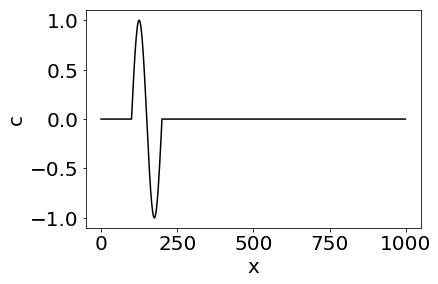

In [9]:
# Initial condition
c0 = np.zeros(1000)
Lx = 100
c0[101:200] = np.sin(2*np.pi*np.arange(101,200)/Lx)
x = np.arange(1000)
plt.plot(x,c0,'k')
plt.xlabel('x')
plt.ylabel('c')

## Exercise: Effects of numerical parameters
Alter the parameters 'dt', 'dx', and 'u' and run the three cells below. Describe the differences as you change the parameters

In [10]:
# Choose parameters
dt = 0.5
dx = 1.0
u  = 1.0*np.ones(c0.shape)
print(max(u)*dt/dx)

0.5


In [11]:
T = 10
nt = T/dt # number of timesteps
# Numerical solution
c1 = c0
for i in np.arange(nt):
    c1 = centered_difference1D(c1,u,dt,dx)

Maximum value is 1.0099135220983153


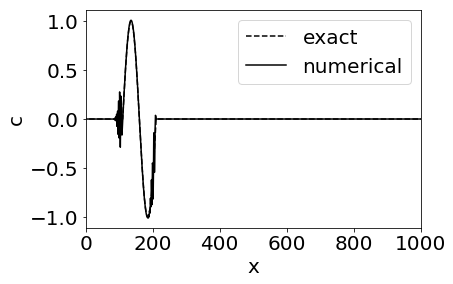

In [12]:
plt.plot(x+u*dt*nt,c0,'k--')
plt.plot(x,c1,'k')
plt.xlim((0,1000))
plt.legend(('exact','numerical'))
plt.xlabel('x')
plt.ylabel('c')
print('Maximum value is '+str(max(c1)))

## Convergence condition
In the past two examples, we saw that the amount of numerical dissipation and the stability of the solution depends on the factor $\frac{u \Delta t}{\Delta x}$. This value is called the "convergence condition" or Courant–Friedrichs–Lewy (CFL) condition and must be less than or equal to one. This is an important thing to keep in mind when simulating partial differential equations.

## Numerical methods and grids

In Earth sciences, most models do not use finite differencing, instead they will use
- Finite volume method
- Finite element method
- Spectral methods

The preferred numerical method and solver will depend on the application.

The other aspect of a model set-up that is important to consider is the grid type. Grid types are classified into Arakawa grids.

(image Delandmeter and Erik van Sebille 2018)
<img src="grids.png" alt="Arakawa grid" style="width: 500px;"/>

**Vertical** grids may be sigma grids or pressure grids (or hybrids)

# Opening the black box

Large models will use a compiled language (most often C or Fortran), which can be optimized to run quickly

#### Coding in Fortran
A few important pointers for coding in Fortran:
- All variables need to be declared with a type

INTEGER i, j, k

- Comments are made with "C" or "!"
- Programs are organized as a main program and subroutines (these may be in different files)

#### Compiling
Compiled languages need to be recompiled into an *executable* every time you make a change to the source code

Make is the program that directs the compiler how to link different parts of the code together using a Makefile. The Makefile includes information that is specific to your model, computer, and compiler

### Structure of the model
The directory structure of the model 
- model: contains the main source code.
    - src: source code
    - inc: includes files
- eesupp: contains the execution environment source code. 
- pkg: contains the source code for the packages, many of which are parameterizations
- doc: contains MITgcm documentation
- tools: contains various useful tools. For example, genmake2 is a script written in bash that should be used to generate your makefile.
- verification: contains the model examples
- jobs: contains sample job scripts for running MITgcm

#### Includes files

These have model components, particularly variables and are used with "include" statements

ifdef ALLOW_GMREDI  
&emsp;include "GMREDI.h"  
endif

#### Your model run

You won't modify any of the main code for a typical model run, instead you will copy the codes to your own directory that contains your own model set-up. This folder has a similar structure
- build
- code
- input
- results
- run

#### Build

Where the compiled files will be placed

#### Code
Modified source code and includes files should be placed here

#### Input

Any input files are placed here, including data to be read in and the namelist

#### Results

Contains text files with output from the model run

#### Run

What we've been waiting for! Where you submit your job and get the output!

## Exercise: Reading Fortran code
- Go to [diffchecker.com](https://www.diffchecker.com/diff) and compare the differences between a file in the "model" folder and a file with the same filename in one of the examples.  
- Choose one file with a ".F" file extension and one file with a ".h" file extension. Explain the differences between the changes made in these two types of files

## Input/Output

We don't want to have to recompile everytime we make a change so some data (e.g. forcing or boundary conditions) and parameter values (e.g. grid resolution) can be in input files. These input files are often read into groups of variables called *namelists*

## Exercise: what's in the namelists?

The input parameters for the namelists are in a file called 'data' in the MITgcm 'input' directory. How would you change the variables that relate to the CFL condition in an MITgcm namelist? Give examples of two different cases and the parameters that you would choose.